In [1]:
# Step 1: Define constants

import numpy as np
from torch.nn import CrossEntropyLoss, NLLLoss

# Run specific
DATASET = "mnist" # "mnist", "fashion-mnist", "cifar"
PERTURB = False
SIMPLE_NEURONS_PER_FEATURE_PER_ROW = 8
CHOOSE_NEW_RECEPTIVE_FIELDS = False
CHOOSE_NEW_TRAINING_DATA = False
FORCE_EXTRACT_FEATURES = False
RUN = "1"
# Constants
CLASSES = 4
BATCH_SIZE = 256
FEATURE_BRIGHTNESS = 2
FEATURE_ANGLES = 2
FEATURE_FREQUENCIES = 1

#For dynamic kernels
KERNEL="dynamic"
MIN_KERNEL_SIZE = 5
MIN_KERNEL_SIZE_GABOR = 2

#Derived:
TOTAL_FEATURES_PER_SITE = FEATURE_BRIGHTNESS + FEATURE_ANGLES * FEATURE_FREQUENCIES * 2 # 2 values per gabor
TOTAL_FEATURES = SIMPLE_NEURONS_PER_FEATURE_PER_ROW * SIMPLE_NEURONS_PER_FEATURE_PER_ROW * TOTAL_FEATURES_PER_SITE

FILENAME_PREFIX = f'v3-{DATASET}-r{RUN}-n{TOTAL_FEATURES}-k{KERNEL}'

if DATASET == "cifar":
  IMAGE_WIDTH = 32
  TARGETS = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])  
elif DATASET == "fashion-mnist":
  IMAGE_WIDTH = 28
  TARGETS = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]) 
else: 
  IMAGE_WIDTH = 28
  TARGETS = np.array([0,1,2,3,4,5,6,7,8,9])

## Settings
DEBUG = False


In [2]:
# Step 2: Necessary imports

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arrow
from itertools import cycle
import random
import os.path as path
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from datetime import datetime

# Additional torch-related imports
import torch
from torch import Tensor, cat, no_grad, manual_seed
from torch.nn import Linear, MSELoss, Softmax
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

# Project specific imports
from canonicallayers.brightnessextractor import extractBrightness, extractBrightnessAt
from canonicallayers.gaborfilterextractor import extract_power_feats
from canonicallayers.perturbations import skew, rotate, noise, elastic_transform
algorithm_globals.random_seed = 42

In [3]:
# Step 3: Prepare Training data
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = BATCH_SIZE
n_samples = CLASSES * 10000  # We will concentrate on the first 6000 * CLASSES samples

if(CHOOSE_NEW_TRAINING_DATA or (not path.isfile(f'checkpoints/{FILENAME_PREFIX}-training.pt'))):
  print("Creating new training set...")
  # Use pre-defined torchvision function to load MNIST train data
  if DATASET == "cifar":
    X_train = datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
    )
  elif DATASET == "fashion-mnist":
    X_train = datasets.FashionMNIST(
        root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
    )    
  else:
    X_train = datasets.MNIST(
        root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
    )    
  # Filter out labels (originally 0-9), leaving only labels 0 and 1
  idx = np.where(np.array(X_train.targets) < CLASSES)[0][:n_samples]
  X_train.data = X_train.data[idx]
  X_train.targets = np.array(X_train.targets)[idx]

  print("X_train.data", X_train.data.shape)
  # Define torch dataloader with filtered data
  train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
  torch.save(train_loader, f'checkpoints/{FILENAME_PREFIX}-training.pt')
else:
  print("loading existing training set...")
  train_loader = torch.load(f'checkpoints/{FILENAME_PREFIX}-training.pt')

Creating new training set...
X_train.data torch.Size([24754, 28, 28])


images shape torch.Size([256, 1, 28, 28])


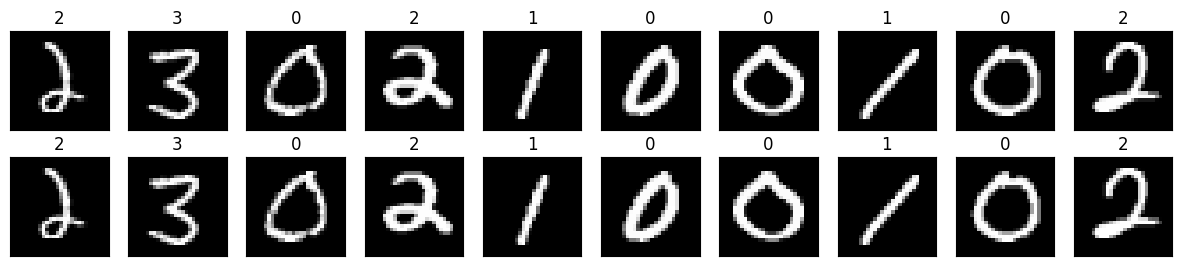

In [4]:
# Step 4 - Visualize dataset

n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, sharex=True, figsize=(15, 3))
images, targets = data_iter.__next__()
print("images shape", images.shape)

while n_samples_show > 0:
    originalImage = images[n_samples_show,0]
      
    if(PERTURB):
      perturbation = "none"
      match random.randint(0, 3):
          case 0:
            perturbedImage = skew(originalImage.numpy())
            perturbation = "skew"
          case 1:
            angle = 3*np.random.random()/5
            perturbedImage = rotate(originalImage.numpy(), angle)
            perturbation = f"rotate {np.round(angle*180/np.pi)}°"
          case 2:
            perturbedImage = noise(originalImage.numpy())
            perturbation = "noise"
          case _:
            perturbedImage = elastic_transform(originalImage.numpy())
            perturbation = "elastic"
      perturbedData = torch.tensor(perturbedImage).unsqueeze(0).unsqueeze(0)

    axes[0,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
    axes[0,n_samples_show - 1].set_xticks([])
    axes[0,n_samples_show - 1].set_yticks([])
    axes[0,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])
    if(PERTURB):
      axes[1,n_samples_show - 1].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title("{}".format(perturbation))
    else:
      axes[1,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])

    n_samples_show -= 1

***

### Step 4: Split test data into train and test batches


In [5]:
# Step 5 - Prepare Test Data
# -------------

# Set test shuffle seed (for reproducibility)
manual_seed(5)

n_samples = CLASSES * 1000  # We will concentrate on 1000 * CLASSES samples

if(CHOOSE_NEW_TRAINING_DATA or (not path.isfile(f'checkpoints/{FILENAME_PREFIX}-testing.pt'))):
  print("Creating new testing set...")
  # Use pre-defined torchvision function to load MNIST test data
  if DATASET == "cifar":
    X_test = datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
    )
  elif DATASET == "fashion-mnist":
    X_test = datasets.FashionMNIST(
        root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
    )    
  else:
    X_test = datasets.MNIST(
        root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
    )      

  # Filter out labels (originally 0-9), leaving only labels 0 and 1
  idx = np.where(np.array(X_test.targets) < CLASSES)[0][:n_samples]
  X_test.data = X_test.data[idx]
  X_test.targets = np.array(X_test.targets)[idx]

  # Define torch dataloader with filtered data
  test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)
  torch.save(test_loader, f'checkpoints/{FILENAME_PREFIX}-testing.pt')
else:
  print("loading existing testing set...")
  test_loader = torch.load(f'checkpoints/{FILENAME_PREFIX}-testing.pt')

Creating new testing set...


In [6]:
# Step 6 - Setup Feature Extraction parameters

dataWidth = SIMPLE_NEURONS_PER_FEATURE_PER_ROW
imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
gaborImgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1 # IMAGE_WIDTH - MIN_KERNEL_SIZE_GABOR +1

if(CHOOSE_NEW_RECEPTIVE_FIELDS or (not path.isfile(f'checkpoints/{FILENAME_PREFIX}-gaborReceptiveFields.pt'))): 
  print("Creating new gabor filters...")
  gaborReceptiveFields = torch.randint(0,gaborImgWidth * gaborImgWidth, (dataWidth, dataWidth))
  gaborKernels = torch.clone(gaborReceptiveFields)
  gaborKernels = gaborKernels.apply_(lambda x: random.randint(
    MIN_KERNEL_SIZE, 
    min([(IMAGE_WIDTH-x//gaborImgWidth), (IMAGE_WIDTH-x%gaborImgWidth)])))
  gaborAngleTunings = torch.FloatTensor(FEATURE_ANGLES, dataWidth, dataWidth).uniform_(0, np.pi)
  gaborFrequencyTunings = torch.FloatTensor(FEATURE_FREQUENCIES, dataWidth, dataWidth).uniform_(1./10., 1./2.)
  gaborBrightnessTunings = torch.FloatTensor(FEATURE_BRIGHTNESS, dataWidth, dataWidth).uniform_(0.0, 1.0)

  torch.save(gaborReceptiveFields, f"checkpoints/{FILENAME_PREFIX}-gaborReceptiveFields.pt")
  torch.save(gaborKernels, f"checkpoints/{FILENAME_PREFIX}-gaborKernels.pt")
  torch.save(gaborAngleTunings, f"checkpoints/{FILENAME_PREFIX}-gaborAngleTunings.pt")
  torch.save(gaborFrequencyTunings, f"checkpoints/{FILENAME_PREFIX}-gaborFrequencyTunings.pt")
  torch.save(gaborBrightnessTunings, f"checkpoints/{FILENAME_PREFIX}-gaborBrightnessTunings.pt")
else:
  print("loading existing gabor filters...")
  gaborReceptiveFields = torch.load(f"checkpoints/{FILENAME_PREFIX}-gaborReceptiveFields.pt")
  gaborKernels = torch.load(f"checkpoints/{FILENAME_PREFIX}-gaborKernels.pt")
  gaborAngleTunings = torch.load(f"checkpoints/{FILENAME_PREFIX}-gaborAngleTunings.pt")
  gaborFrequencyTunings = torch.load(f"checkpoints/{FILENAME_PREFIX}-gaborFrequencyTunings.pt")
  gaborBrightnessTunings = torch.load(f"checkpoints/{FILENAME_PREFIX}-gaborBrightnessTunings.pt")


Creating new gabor filters...


In [7]:
# Step 17 - Plot feature extraction kernels

def plotKernel(ax, locations, kernels, brightnessTunings, angleTunings, title, feature):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
  imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
  ax.plot([0, 0],[IMAGE_WIDTH, IMAGE_WIDTH])
  cycol = cycle('bgrcmk')
  Y = []
  X = []
  C=[]
  S=[]
  kernelSize=[]
  tuningX=[]
  tuningY=[]
  tuningValue=np.array([])
  anyOneTuningValue = []
  # print("locations", locations.shape, "angleTunings", angleTunings)
  for iy, ix in np.ndindex(locations.shape):
    # if(angleTunings.shape[0] < iy+1):
    #   print("breaking", "angleTunings.shape", angleTunings.shape, "iy+1", iy+1)
    #   break
    y = locations[iy, ix] // imgWidth
    x = locations[iy, ix] % imgWidth
    Y.append(y.item())
    X.append(x.item())
    ks = kernels[iy, ix].item()
    # print("ks", ks)
    kernelSize.append(ks * ks * 2000/(IMAGE_WIDTH*IMAGE_WIDTH))
    tuningX.append(x + ks/2)
    tuningY.append(y + ks/2)
    size = kernels[iy, ix].item()
    S.append(size)
    # print("iy", iy, "ix", ix, "angleTunings[iy, ix]", angleTunings[iy, ix].shape, "tuningValue", len(tuningValue))
    tuningValue = np.concatenate((tuningValue, angleTunings[:, iy, ix].numpy()))
    anyOneTuningValue.append(np.random.choice(angleTunings[:, iy, ix].numpy().astype(int)))
    angles = angleTunings[:, iy, ix].numpy()
    brightnesses = brightnessTunings[:, iy, ix].numpy()
    topX = x.item()
    topY = IMAGE_WIDTH-y.item()-size
    radius = 1
    centerX = topX + int(size/2)
    centerY = topY + int(size/2)
    color = next(cycol)
    if(feature == "kernel"):
      ax.add_patch(Rectangle((topX, topY), size, size, facecolor= 'none', edgecolor=color, alpha=0.5))
    
    # ax.add_patch(Circle((centerX, centerY), radius=radius, alpha=0.1))
    for a in angles:
      dx = int((size/2) * np.cos(a))
      dy = - int((size/2) * np.sin(a))
      # print("center", centerX, centerY, "angle", a * 180/np.pi, "size", size, "dx", dx, "dy", dy)
      if(feature == "angle"):
        ax.add_patch(Arrow(centerX, centerY, dx, dy, alpha=0.2, facecolor=color))
    for br in brightnesses:
      if(feature == "brightness"):
        ax.add_patch(Circle((centerX, centerY), radius=size*br/3, alpha=0.15, facecolor=color))

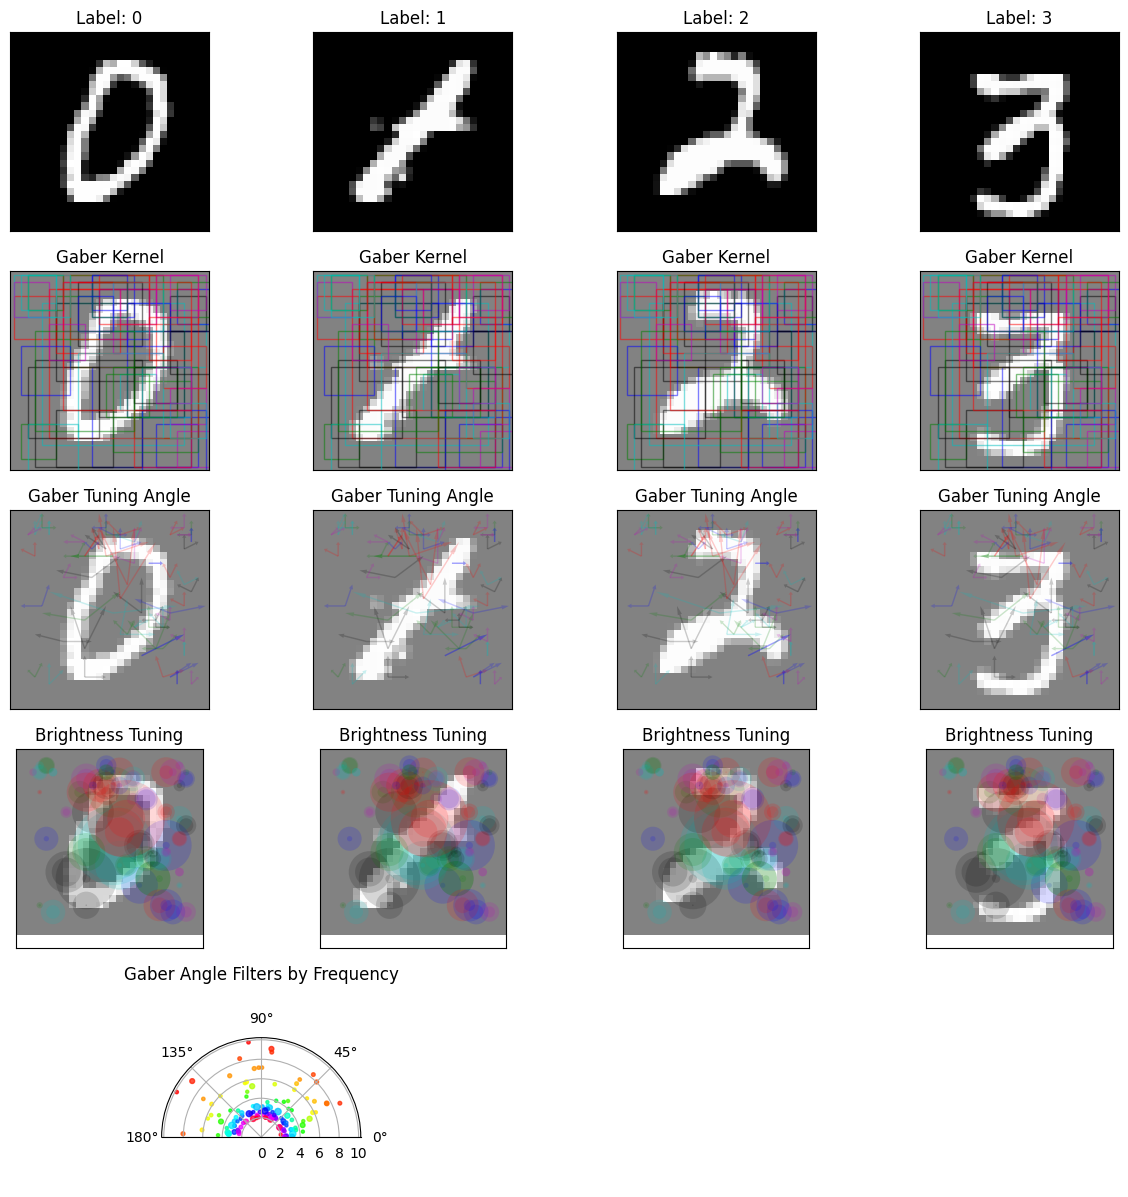

In [8]:
# Step 18 - Predict
def plot(axes, count, data, idx, perturbations, target, feature):
  perturbedData = data[idx,0, :, :].unsqueeze(1)
  axes[0,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
  axes[0,count].set_xticks([])
  axes[0,count].set_yticks([])
  if(PERTURB):
    axes[0,count].set_title("{}, Label: {}".format(perturbations[idx], TARGETS[target[idx].item()]))
  else:
    axes[0,count].set_title("Label: {}".format(TARGETS[target[idx].item()]))
  axes[1,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray", alpha=0.2)
  axes[2,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray", alpha=0.2)
  axes[3,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray", alpha=0.2)
  if(feature == "kernel"):
    plotKernel(axes[1,count], gaborReceptiveFields, gaborKernels, gaborBrightnessTunings, gaborAngleTunings, "Gaber Kernel", feature)
  elif(feature == "angle"):
    plotKernel(axes[2,count], gaborReceptiveFields, gaborKernels, gaborBrightnessTunings, gaborAngleTunings, "Gaber Tuning Angle", feature)
  elif(feature == "brightness"):
    plotKernel(axes[3,count], gaborReceptiveFields, gaborKernels, gaborBrightnessTunings, gaborAngleTunings, "Brightness Tuning", feature)


fig, axes = plt.subplots(nrows=5, ncols=CLASSES, figsize=(15, 15))

dataWidth = SIMPLE_NEURONS_PER_FEATURE_PER_ROW
imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1

for batch_idx, (data, target) in enumerate(train_loader):
  perturbations = []
  # print("target", target.shape)
  class1Indices = (target == 0).nonzero()
  class2Indices = (target == 1).nonzero()
  class3Indices = (target == 2).nonzero()
  class4Indices = (target == 3).nonzero()
  plot(axes, 0, data, class1Indices[0], perturbations, target, "angle")
  plot(axes, 1, data, class2Indices[0], perturbations, target, "angle")
  plot(axes, 2, data, class3Indices[0], perturbations, target, "angle")
  plot(axes, 3, data, class4Indices[0], perturbations, target, "angle")

  plot(axes, 0, data, class1Indices[0], perturbations, target, "kernel")
  plot(axes, 1, data, class2Indices[0], perturbations, target, "kernel")
  plot(axes, 2, data, class3Indices[0], perturbations, target, "kernel")
  plot(axes, 3, data, class4Indices[0], perturbations, target, "kernel")

  plot(axes, 0, data, class1Indices[0], perturbations, target, "brightness")
  plot(axes, 1, data, class2Indices[0], perturbations, target, "brightness")
  plot(axes, 2, data, class3Indices[0], perturbations, target, "brightness")
  plot(axes, 3, data, class4Indices[0], perturbations, target, "brightness")


  axes[4,0].remove()
  axes[4,1].remove()
  axes[4,2].remove()
  axes[4,3].remove()

  ax = fig.add_subplot(5, 4, (17, 18), projection='polar')
  ax.set_title("Gaber Angle Filters by Frequency")
  ax.set_thetamin(0)
  ax.set_thetamax(180)
  cTunings = gaborAngleTunings.unsqueeze(0).repeat(FEATURE_FREQUENCIES, 1,1,1)
  cFrequencies = gaborFrequencyTunings.unsqueeze(1).repeat(1, FEATURE_ANGLES, 1,1)
  cKernels = gaborKernels.unsqueeze(0).unsqueeze(1).repeat(FEATURE_FREQUENCIES, FEATURE_ANGLES, 1,1)

  # print("gaborAngleTunings", gaborAngleTunings.unsqueeze(0).shape, "gaborFrequencyTunings", gaborFrequencyTunings.unsqueeze(1).shape, "gaborKernels", gaborKernels.unsqueeze(0).unsqueeze(1).shape)
  ax.scatter(cTunings, 1/cFrequencies, c=cFrequencies, s=cKernels, cmap='hsv', alpha=0.75)
  break


In [9]:
# Step 8 - Feature extraction functions

def extractFeatures(data, gaborReceptiveFields, gaborBrightnessTunings, gaborAngleTunings, gaborFrequencyTunings, gaborKernels):
  f = torch.zeros(data.shape[0],TOTAL_FEATURES_PER_SITE,SIMPLE_NEURONS_PER_FEATURE_PER_ROW,SIMPLE_NEURONS_PER_FEATURE_PER_ROW)
  #Fill Brigtness, orientation input
  for bi in range(0, data.shape[0]):
    print(bi, end=" ")
    for i in range(0, SIMPLE_NEURONS_PER_FEATURE_PER_ROW):
      for j in range(0,SIMPLE_NEURONS_PER_FEATURE_PER_ROW):
        featureIndex = 0
        rfSpot = gaborReceptiveFields[i][j].item()
        rfKernelSize = gaborKernels[i][j].item()
        for br in range(0, FEATURE_BRIGHTNESS):
          brightnessTuning = gaborBrightnessTunings[br][i][j].item()
          brightnessValue = extractBrightnessAt(data[bi].unsqueeze(0), brightnessTuning, rfSpot//imgWidth, rfSpot%imgWidth, rfKernelSize)
          f[bi][featureIndex][i][j] = brightnessValue
          featureIndex += 1
        for a in range(0, FEATURE_ANGLES):
          for fr in range(0, FEATURE_FREQUENCIES):
            gaborAngle = gaborAngleTunings[a][i][j].item()
            gaborFrequency = gaborFrequencyTunings[fr][i][j].item()
            # print("Gaber inputs", data.shape, rfKernelSize, rfSpot//imgWidth, rfSpot%imgWidth, gaborFrequency, gaborAngle)
            kernel, power_feats, power_img = extract_power_feats(data[bi].unsqueeze(0), rfKernelSize, rfSpot//gaborImgWidth, rfSpot%gaborImgWidth, gaborFrequency, gaborAngle)
            # print("orientation", o)
            # print("Gaber output", power_feats[0])
            f[bi][featureIndex][i][j] = power_feats[0]
            f[bi][featureIndex+1][i][j] = power_feats[1]
            featureIndex += 2
  return f

In [10]:
# Step 14 - Extact features
def batchExtractFeatures(loader, name):
  # Define model, optimizer, and loss function
  start_time = datetime.now()
  resume_stats = [-1]
  if((not FORCE_EXTRACT_FEATURES) and path.isfile(f'checkpoints/{FILENAME_PREFIX}-{name}-resumestats.pt')):
    resume_stats = torch.load(f'checkpoints/{FILENAME_PREFIX}-{name}-resumestats.pt')
    features = torch.load(f"checkpoints/{FILENAME_PREFIX}-{name}-features.pt")
    print("features", features.shape)
  else:
    features = torch.tensor(())
  if(FORCE_EXTRACT_FEATURES or (not path.isfile(f'checkpoints/{FILENAME_PREFIX}-{name}-features.pt') or resume_stats[0] < (len(loader.dataset)//BATCH_SIZE+1))):
    print("resume stats", resume_stats)
    print(f"Extacting new {name} features...")
    print(DATASET, f"{name} Set:", len(loader.dataset), "Batch Size:", BATCH_SIZE, "Number of batches:", (len(loader.dataset)//BATCH_SIZE)+1)
    
    for batch_idx, (data, target) in enumerate(loader):
        if(batch_idx <= resume_stats[0]):
          print(batch_idx, "already processed")
          continue
        batch_start_time = datetime.now()
        print(batch_idx, end=" ")
        x = extractFeatures(data, gaborReceptiveFields, gaborBrightnessTunings, gaborAngleTunings, gaborFrequencyTunings, gaborKernels)
        features = torch.cat((features, x), 0)
        torch.save(features, f"checkpoints/{FILENAME_PREFIX}-{name}-features.pt")
        resume_stats[0] = batch_idx
        torch.save(resume_stats, f"checkpoints/{FILENAME_PREFIX}-{name}-resumestats.pt")
        batch_end_time = datetime.now()
        batch_elapsed = batch_end_time - batch_start_time
        print("Elapsed", batch_elapsed.total_seconds())
    end_time = datetime.now()
    elapsed = end_time - start_time
    print("Elapsed", elapsed.total_seconds())
    return features
  else:
    print("loading exising training features...")
    features = torch.load(f"checkpoints/{FILENAME_PREFIX}-{name}-features.pt")
    return features

In [11]:
train_features = batchExtractFeatures(train_loader, "train")
print("train features", train_features.shape)
test_features = batchExtractFeatures(test_loader, "test")
print("test features", test_features.shape)


resume stats [-1]
Extacting new train features...
mnist train Set: 24754 Batch Size: 256 Number of batches: 97
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 2

In [12]:
import qiskit.tools.jupyter

%qiskit_version_table